In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
batch_size=32

In [4]:
data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_outputs_poor.csv", header=None)

scaler = MinMaxScaler()
data_output_scaled = scaler.fit_transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=10000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :1].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data_pd.iloc[:, 1:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :1].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 1:].values, dtype=torch.float32)

In [5]:
data

0    0    1    2      3         4         5         6    \
43660  31.097906  0.0  0.0  0.0  0.125  0.166667  0.176471  0.363636   
87278  57.419376  0.0  0.0  0.0  0.000  0.166667  0.235294  0.272727   
14317  54.637019  0.0  0.0  0.0  0.125  0.416667  0.352941  0.272727   
81932  51.780880  0.0  0.0  0.0  0.000  0.166667  0.470588  0.409091   
95321  69.767399  0.0  0.0  0.0  0.125  0.333333  0.352941  0.454545   
...          ...  ...  ...  ...    ...       ...       ...       ...   
59828   3.382317  0.0  0.0  0.0  0.125  0.000000  0.294118  0.318182   
47957  36.627062  0.0  0.0  0.0  0.250  0.416667  0.470588  0.409091   
42429  58.340090  0.0  0.0  0.0  0.125  0.416667  0.294118  0.318182   
76505  50.392602  0.0  0.0  0.0  0.000  0.333333  0.411765  0.454545   
49578  32.819554  0.0  0.0  0.0  0.000  0.166667  0.176471  0.272727   

            7         8    ...       91        92        93        94   \
43660  0.392857  0.363636  ...  0.809249  0.787356  0.782857  0.803468   
87278  0.357143  0.333333  ...  0.520231  0.482759  0.474286  0.485549   
14317  0.535714  0.545455  ...  0.554913  0.528736  0.525714  0.543353   
81932  0.428571  0.515152  ...  0.543353  0.534483  0.565714  0.601156   
95321  0.428571  0.454545  ...  0.265896  0.281609  0.297143  0.329480   
...         ...       ...  ...       ...       ...       ...       ...   
59828  0.214286  0.333333  ...  0.815029  0.810345  0.805714  0.797688   
47957  0.535714  0.484848  ...  0.895954  0.862069  0.857143  0.832370   
42429  0.535714  0.424242  ...  0.456647  0.436782  0.440000  0.410405   
76505  0.428571  0.363636  ...  0.560694  0.551724  0.565714  0.566474   
49578  0.321429  0.424242  ...  0.803468  0.827586  0.834286  0.820809   

            95        96        97        98        99        100  
43660  0.810345  0.822857  0.823864  0.825581  0.797688  0.787356  
87278  0.482759  0.457143  0.488636  0.500000  0.485549  0.500000  
14317  0.511494  0.514286  0.511364  0.523256  0.502890  0.522989  
81932  0.614943  0.571429  0.551136  0.552326  0.554913  0.586207  
95321  0.293103  0.325714  0.306818  0.302326  0.306358  0.304598  
...         ...       ...       ...       ...       ...       ...  
59828  0.793103  0.794286  0.772727  0.784884  0.768786  0.775862  
47957  0.827586  0.817143  0.795455  0.825581  0.843931  0.850575  
42429  0.419540  0.434286  0.431818  0.441860  0.456647  0.448276  
76505  0.574713  0.571429  0.568182  0.598837  0.583815  0.586207  
49578  0.844828  0.834286  0.789773  0.831395  0.820809  0.827586  

[10000 rows x 102 columns]

In [6]:
train_inputs.shape[0]

8000

In [7]:
torch.manual_seed(1)

In [8]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([8000, 102])

In [9]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [10]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [11]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=101, condition_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [12]:
discriminator = ConditionalDiscriminator()

In [13]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1, output_dim=101):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z, conditions):
        # Concatenate noise and condition
        x = torch.cat([z, conditions], dim=1)
        return self.model(x)

generator = ConditionalGenerator()

In [14]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [15]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [16]:
for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0:  # Adjust this number to control how often you log
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.7649145126342773
Epoch: 0 Step: 0 Loss G.: 0.49185711145401
Epoch: 0 Step: 100 Loss D.: 0.28281697630882263
Epoch: 0 Step: 100 Loss G.: 7.058128356933594
Epoch: 0 Step: 200 Loss D.: 0.2468133419752121
Epoch: 0 Step: 200 Loss G.: 2.2194435596466064
Epoch: 1 Step: 0 Loss D.: 0.24611179530620575
Epoch: 1 Step: 0 Loss G.: 2.409698486328125
Epoch: 1 Step: 100 Loss D.: 0.3452543616294861
Epoch: 1 Step: 100 Loss G.: 1.200659155845642
Epoch: 1 Step: 200 Loss D.: 0.9009564518928528
Epoch: 1 Step: 200 Loss G.: 0.4785500466823578
Epoch: 2 Step: 0 Loss D.: 0.8932508230209351
Epoch: 2 Step: 0 Loss G.: 0.7356820106506348
Epoch: 2 Step: 100 Loss D.: 1.319822907447815
Epoch: 2 Step: 100 Loss G.: 3.8611936569213867
Epoch: 2 Step: 200 Loss D.: 0.5857806205749512
Epoch: 2 Step: 200 Loss G.: 0.8365991115570068
Epoch: 3 Step: 0 Loss D.: 1.1425893306732178
Epoch: 3 Step: 0 Loss G.: 0.4810902178287506
Epoch: 3 Step: 100 Loss D.: 0.6554141044616699
Epoch: 3 Step: 100 Loss G.: 0.921

In [20]:
import random

# Pick N random examples from your validation set
n_samples = 5
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [21]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

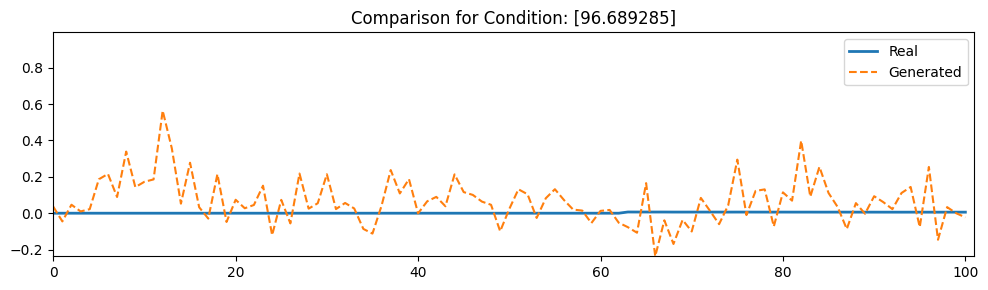

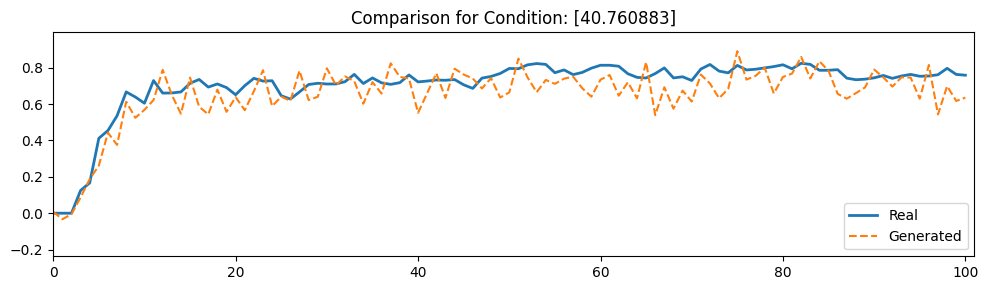

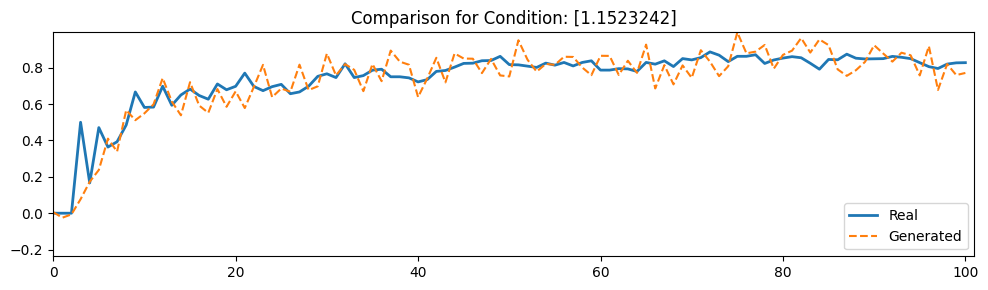

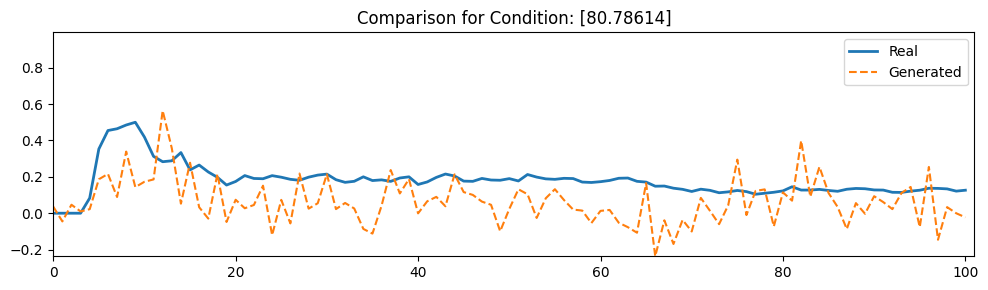

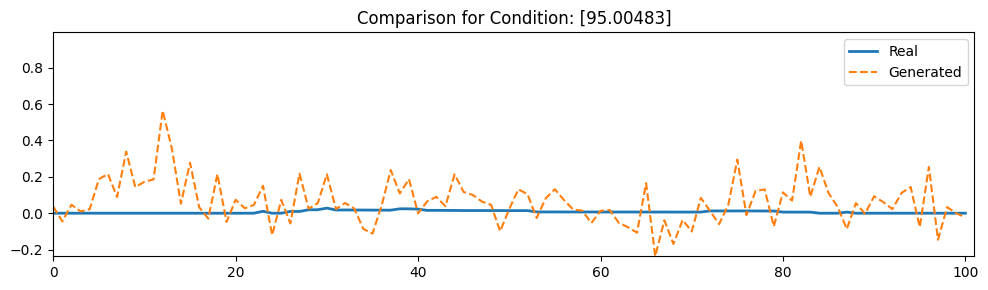

In [22]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(n_samples):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()